In [43]:
#1
#%matplotlib inline
%matplotlib notebook
from sklearn.utils import shuffle
import pandas as pd
import csv
import numpy as np
import time 
from math import radians, cos, sin, asin, sqrt
import re, math
# for database operations
import sys
import csv
import pandas as pd
from haversine import haversine
import datetime
import matplotlib.pyplot as plt
import pylab as pl
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import jaccard_similarity_score 

In [44]:
#2

def ST_DBSCAN(points,max_distance,MinPts,dayRadius):
    global visited 
    visited = []
    noise = []
    c_neighbors = []
    cluster_id = 0
    clusters = []
    in_cluster = []
    for p in points: 
        if p not in visited:
            # neighbor_points = []
            visited.append(p)
            NeighborPts = regionQuery(p,points,max_distance,dayRadius)
            if len(NeighborPts) < MinPts:
                noise.append(p)
            else:
                cluster_id = cluster_id + 1
                g = expandCluster(p,NeighborPts,max_distance,MinPts,in_cluster,cluster_id)
                clusters.append(g)
                c_neighbors=NeighborPts+[cluster_id]
                #print c_neighbors
                c_neighbors.append(g)
    return clusters, c_neighbors

#return len(NeighborPts)

def expandCluster(p,NeighborPts,max_distance,MinPts,in_cluster,cluster_id):
    in_cluster.append(p)
    cluster = []
    t_p = list(p) + [cluster_id]
    cluster.append(t_p)
    for point in NeighborPts:
        if point not in visited:
            visited.append(point)
            new_neighbors = regionQuery(point,points,max_distance,dayRadius)
            if len(new_neighbors) >= MinPts: 
                new_neighbors.append(NeighborPts)
            if point not in in_cluster:
                 t_point = list(point) + [cluster_id]
                 in_cluster.append(point)
                 cluster.append(t_point)
    return cluster


def regionQuery(p,points,max_distance,dayRadius):
    neighbor_points = []
    loc1 = (p[0],p[1])
    for j in points:
        if j != p:
            # print 'P is %s and j is %s' % (p[0],j[0])
            if abs(p[2]-j[2]) < dayRadius:
                loc2 = (j[0],j[1])
                dist = haversine(loc1, loc2)
                if dist <= max_distance:
                    neighbor_points.append(j)
    neighbor_points.append(p) 
    return neighbor_points   


In [21]:
#3
max_distance = 80
MaxPts = 10
dayRadius = 30

df = pd.DataFrame.from_csv('D:/Nanohub/TribeFlow/in_STDB_2015_5.csv', sep ='\t', encoding = 'UTF-8', header = None)
df.columns = ['ip','resource_id','datetime','latitude','longitude']
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by = 'resource_id', axis = 0, ascending = True, na_position ='first')
df_no_dups = df.drop_duplicates(subset = ['ip','resource_id'], keep = 'first')
doy = []
for date in df['datetime']:
    doy.append(date.dayofyear)
df['DoY'] = doy

df_10 = df[df.groupby('resource_id').cumcount(ascending=False) >= 10]
distinct_resources = list(df_10['resource_id'].unique())

In [22]:
#4
uniq_ip_2015 = df_10['ip'].unique()
uniq_res_2015 = df_10['resource_id'].unique()
sims = np.zeros((len(uniq_res_2015),len(uniq_ip_2015)))
   

In [5]:
sims.shape

(1505, 11211)

In [23]:
#5 #not necessary for jaccard's
for l in distinct_resources: #range(21095,22000):
    df_filtered = df_10[df_10['resource_id'] == l]
    df_filtered =df_filtered[df_filtered['latitude'] > 0]
    tups = df_filtered.set_index(['latitude'])[['longitude','DoY','resource_id','ip']].to_records().tolist()
    points = tups
    core, neigh = ST_DBSCAN(points,max_distance,MaxPts,dayRadius)
    
    fname = 'D:/Nanohub/results/GIS5/' + str(l) +'.csv'
    
    f = open(fname, 'wt')
    try:
        writer = csv.writer(f, lineterminator = '\n')
        #writer.writerow( ('Latitude', 'Longitude', 'DoY' , 'res_id' , 'cluster_id') )

        for j in range(len(core)):
            for i in range(len(core[j])):
                    writer.writerow( core[j][i] )
    finally:
        f.close()

In [31]:
#6 Jaccard
from pathlib import Path


for k in range(len(uniq_res_2015)):
    fstr = Path('D:/Nanohub/results/GIS4/' + str(uniq_res_2015[k]) + '.csv')
    if fstr.is_file():
        df_open = pd.DataFrame.from_csv(fstr, sep =',', encoding = 'UTF-8', header = None)
        df_open.columns = ['longitude','DOY','resource_id','ip','cluster_id']
        ips_of_file = df_open['ip'].unique()
        ips_of_file.sort()
        if len(df_open) > 0:
            for j in range(len(ips_of_file)):
                for i in range(len(uniq_ip_2015)):
                    if ips_of_file[j] == uniq_ip_2015[i]:
                        sims[k][i] = 1
        

In [32]:
print(sims[1])
print(uniq_res_2015[1])

[ 0.  1.  1. ...,  0.  0.  0.]
8


In [34]:
#7 incorrect

for s1 in range(len(sims)):
    #print ('s1',uniq_res_2015[s1])
    arr1 = []
    for s2 in range(len(sims)):
        if s2 != s1:
            
            if jaccard_similarity_score(sims[s1],sims[s2]) > 0.8:
                arr1.append(uniq_res_2015[s2])
    print('---------------------------------------------------')            
    print (len(arr1))

---------------------------------------------------
1504
---------------------------------------------------
1504
---------------------------------------------------
1504
---------------------------------------------------
1504
---------------------------------------------------
1504


KeyboardInterrupt: 

In [42]:
fjacc = open('D:/Nanohub/results/GIS5/jacc5.csv','w')
for s1 in range(len(sims)):
    a1 = sims[s1]
    arr1 = []
    for s2 in range(len(sims)):
        a2 = sims[s2]
        inter_1 = 0
        all_1 = 0
        for i in range(len(a1)):
            all_1 = a1[i] + a2[i]
            if a1[i] == a2[i] and a1[i] == 1:
                inter_1 += 1
        jacc = float(inter_1 / all_1-inter_1)
        if jacc > 0.99:
            arr1.append(uniq_res_2015[s2])
    print (len(arr1))
    ''',arr1)
    if len(arr1) > 0:
        try:
            writer = csv.writer(fjacc, lineterminator = '\n')
            writer.writerow( arr1 )
        finally:
            fjacc.close()
                '''

417
492


KeyboardInterrupt: 

In [16]:
a = [1,2]
len(a)

2

In [4]:
#Read Files for plotting
f1name = 'D:/Nanohub/results/GIS2/' + str(10) +'.csv'
f2name = 'D:/Nanohub/results/GIS2/' + str(11) +'.csv'
f3name = 'D:/Nanohub/results/GIS2/' + str(12) +'.csv'    

In [2]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for l in range(14,20):
    fname = 'D:/Nanohub/results/GIS2/' + str(l) +'.csv'
    df1 = pd.read_csv(fname, sep =',', names = ['Latitude', 'Longitude', 'DoY' , 'res_id' , 'cluster_id'])
    #colour = 2 * np.pi * np.random.rand(l) 
    for cnum in range(1,max(df1['cluster_id'] + 1)):
        #c =  #plt.cm.gist_earth
        curr_df = df1[df1['cluster_id'] == cnum]
        xs = curr_df['Latitude']
        ys = curr_df['Longitude']
        zs = curr_df['DoY']
        ax.scatter(xs, ys, zs, c='b',cmap =plt.cm.gist_earth, marker='o')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Day of the Year')
plt.show()

NameError: name 'plt' is not defined

In [5]:
df1 = pd.read_csv(f1name, sep =',', names = ['Latitude', 'Longitude', 'DoY' , 'res_id' , 'cluster_id'])
df2 = pd.read_csv(f2name, sep =',', names = ['Latitude', 'Longitude', 'DoY' , 'res_id' , 'cluster_id'])
df3 = pd.read_csv(f3name, sep =',', names = ['Latitude', 'Longitude', 'DoY' , 'res_id' , 'cluster_id'])


<IPython.core.display.Javascript object>


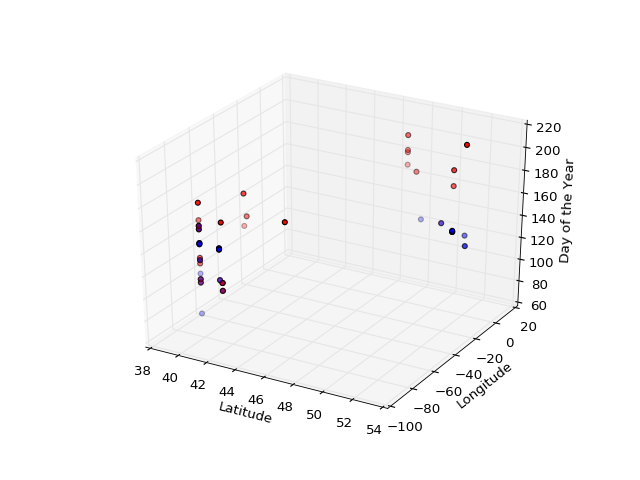

In [6]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for cnum in range(1,max(df1['cluster_id'] + 1)):
    c = cnum * 7
    curr_df = df1[df1['cluster_id'] == cnum]
    xs = curr_df['Latitude']
    ys = curr_df['Longitude']
    zs = curr_df['DoY']
    ax.scatter(xs, ys, zs, c='b', marker='o')
for cnum in range(1,max(df2['cluster_id'] + 1)):
    c = cnum * 7
    curr_df = df2[df2['cluster_id'] == cnum]
    xs = curr_df['Latitude']
    ys = curr_df['Longitude']
    zs = curr_df['DoY']
    ax.scatter(xs, ys, zs, c='r', marker='o')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Day of the Year')
plt.show()

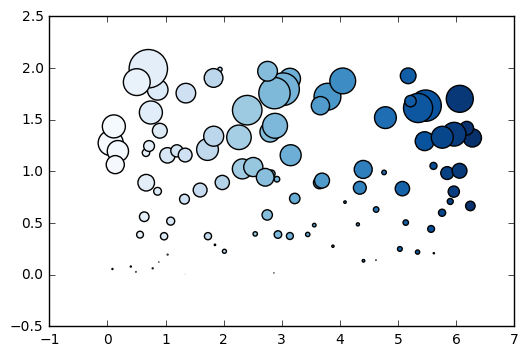

In [22]:
#http://chrisalbon.com/python/set_the_color_of_a_matplotlib.html
%matplotlib inline
n = 100
r = 2 * numpy.random.rand(n)
theta = 2 * numpy.pi * numpy.random.rand(n)
area = 200 * r**2 * numpy.random.rand(n)
colors = theta
c2 = plt.scatter(theta, r, c=colors, s=area, cmap=plt.cm.BrBG)

In [23]:
print(plt.cm.gist_earth[])

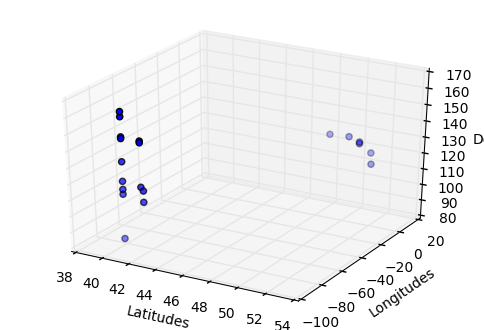

In [49]:
threedee = plt.figure().gca(projection = '3d')
threedee.scatter(df1['Latitude'], df1['Longitude'], df1['DoY'])
threedee.set_xlabel('Latitudes')
threedee.set_ylabel('Longitudes')
threedee.set_zlabel('DoY')
plt.show()

In [18]:
xs = df1['Latitude']
ys = df1['Longitude']
zs = df1['DoY']

In [51]:
import Basemap
map = Basemap()
fig = plt.figure()
ax = Axes3D(fig)
ax.add_collection3d(map.drawcoastlines(linewidth=0.25))
ax.add_collection3d(map.drawcountries(linewidth=0.35))
ax.add_collection3d(map.drawstates(linewidth = 0.1))

ImportError: No module named 'Basemap'